### Import stuff and setup

In [1]:
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import time
import pygmo as pg
from scipy.optimize import rosen
from Cython.Compiler import Options as cyOptions
from scipy.interpolate import UnivariateSpline
import os
import multiprocessing

from runners.vStirapRunner import ExperimentalRunner, Atom, Cavity, LaserCoupling, CavityCoupling

In [9]:
def plot_results(results, plot_pulse=True, ret_pulse_fun=False):
    
    exp_anX, exp_anY = results.get_cavity_number(cavity.R_CL)
    exp_emX, exp_emY = results.get_cavity_emission(cavity.R_CL)
    exp_anP, exp_anM = results.get_cavity_number(atom.R_AL)
    exp_emP, exp_emM = results.get_cavity_emission(atom.R_AL)
    
    exp_sp = results.get_total_spontaneous_emission()
    
    exp_atM, exp_atX, exp_atP, exp_atD = results.get_atomic_population(['gM', 'x0', 'gP', 'd'])
    
    t = results.output.times
    tStep = np.mean(np.ediff1d(t))
    
    n_X = np.trapz(exp_emX, dx=tStep)
    n_Y = np.trapz(exp_emY, dx=tStep)
    n_ph = n_X+n_Y
    n_sp = np.trapz(exp_sp, dx=tStep)
    
    plt.rcParams['text.usetex'] = True
    
    print('Photon emission:', np.round(n_ph,3))
    print('Photon emission in |X>, |Y>:', np.round(n_X,3), np.round(n_Y,3))
    print('Spontaneous emission:', np.round(n_sp,3))
    
    # Plot the results
    f1, ((a1a, a1b),
         (a2a, a2b)) = plt.subplots(2, 2, sharex=True, figsize=(12, 11./2))
    
    a1a.set_title('\\textbf{Cavity mode population}', fontsize=16)
    a1b.set_title('\\textbf{Cavity emission rate} ($1/\mu s$)', fontsize=16, fontweight='bold')
    
    ###
    axA,axB = a1a,a1b
    
    axA.plot(t, exp_anP, 'b', label='$+ (\sigma^{+})$')
    axA.plot(t, exp_anM, 'g', label='$- (\sigma^{-})$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emP, 'b', label='$+ (\sigma^{+})$')
    axB.plot(t, exp_emM, 'g', label='$- (\sigma^{-})$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    ###
    axA,axB = a2a,a2b
    
    axA.plot(t, exp_anX, 'b', label='$X$')
    axA.plot(t, exp_anY, 'g', label='$Y$')
    axA.set_ylabel('Cavity mode population')
    axA.legend(loc=1)
    
    axB.plot(t, exp_emX, 'b', label='$X$')
    axB.plot(t, exp_emY, 'g', label='$Y$')
    axB.set_ylabel('Cavity emission rate, $1/\mu s$')
    axB.legend(loc=1)
    
    f2, (a) = plt.subplots(1, 1, sharex=True, figsize=(12, 11/4))

    a.set_title('\\textbf{Atomic state}', fontsize=16)
    
    a.plot(t, exp_atM, 'b', label='$gM$')
    a.plot(t, exp_atP, 'g', label='$gP$')
    a.plot(t, exp_atX, '--r', label='$x0$')
    a.plot(t, exp_atD, '--y', label='$d$')
    
    a.set_xlabel('Time, $\mu s$')
    a.set_ylabel('Population')
    a.legend(loc=2)
    
    if plot_pulse:
        laser_couplings = results.compiled_hamiltonian.laser_couplings
    
        i_las = 1 if len(laser_couplings) > 1 else ''
        for laser_coupling in laser_couplings:
            omega = laser_coupling.omega0
            pulse = laser_coupling.pulse_shape
            args = laser_coupling.args_ham
    
            for k,v in args.items():
                if type(v)==np.ndarray:
                    v = v.tolist()
                pulse = pulse.replace(k,str(v))
            if 'piecewise' in pulse:
                # Certain np functions (e.g. np.sin) don't play well with piecewise functions.
                # Fix is to have the function evaluated at every time, rather that over the time array.
                pulse = 'lambda t_list: ['+ pulse + ' for t in t_list]'
            else:
                pulse = 'lambda t: ' + pulse
    
            pulse_fn = eval(pulse)
            print(pulse)
            print(pulse_fn)
    
            for a in [a1a, a1b, 
                  a2a, a2b,
                  a]:
                aB = a.twinx()
                aB.plot(t, [omega*x for x in pulse_fn(t)], '--', label=str(i_las)+'$\Omega(t)$')
                aB.legend(loc=4)
            try:
                i_las+=1
            except:
                pass
    
            if ret_pulse_fun: return pulse_fn

### Pygmo testing

Define a problem with a similar architecture to our 'Runners' and 'Results' classes (but with a simpler Rosenbrock function to optimise), and compare how much quicker it is to parallelise different optimisations.

In [3]:
class DummeyRes():
    def __init__(self, res):
        self.res = res
        
    def get(self):
        return self.res

class DummeyExp():
    
    def __init__(self, args, args_warehouse):
        # print('init', os.getpid())
        self.args = args
        args_warehouse.put((os.getpid(), DummyCompArgs(args[0])))
        print('Exp.__init__, PID:',  os.getpid(),
              ', warehouse: ',  args_warehouse.fetch(),
              ', repr(warehouse): ', repr(args_warehouse))
        
    def run(self):
        # print('run', os.getpid())
        return DummeyRes(rosen(self.args))
    
class DummyCompArgs():
    
    def __init__(self, args):
        self.args = args
        
    def get(self):
        return self.args
    
    # def __getstate__(self):
    #     print('DummyCompArgs.__getstate__()', self.__dict__)
    #     return self.__dict__
        
    def __repr__(self):
        '''
        Make the __repr__ something shorter and more readable for simplicity.
        '''
        return str(int(self.args))
    
__args_warehouse = []

class DummyArgsWarehousePipe():

    @classmethod
    def put(cls, args):
        # print('put', os.getpid())
        global __args_warehouse
        __args_warehouse.append(args)

    @classmethod    
    def fetch(cls):
        global __args_warehouse
        return __args_warehouse

    @classmethod
    def clear(cls):
        global __args_warehouse
        __args_warehouse = []

args_warehouse = DummyArgsWarehousePipe
args_warehouse.clear()
args_warehouse.put((os.getpid(),'HERE'))

class BoundRosen():
    
    def __init__(self, dim):
        self.dim = dim

    
    def fitness(self, x):
        global args_warehouse
        # print('Problem.__fitness__, PID:', os.getpid(), ', repr(Problem): ', repr(self),
        #       ', Process: ', multiprocessing.current_process().pid,
        #       ', warehouse: ',  self.get_warehouse().fetch(),
        #       ', repr(warehouse): ', repr(self.get_warehouse()))
        exp = DummeyExp(x, args_warehouse)
        res = exp.run()
        return [res.get()] # pygmo requires fitness vectors
    
    def get_name(self):
        return "Bound Rosen"
    
    def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)
    
    def get_bounds(self):
        return ([-5]*self.dim,[5]*self.dim)


In [8]:
algo = pg.de(gen = 1)
prob = pg.problem(BoundRosen(2000))

pg.mp_island.init_pool()

n_cycles = 2
archi = pg.archipelago(n = 2,
                       algo = algo,
                       prob = prob,
                       pop_size = 5,
                       udi = pg.mp_island())

args_warehouse.put((os.getpid(),'HERE 2'))

i=0
while i<n_cycles:
    print('Main process:', os.getpid())
    archi.evolve()
    print(archi)
    archi.wait_check()
    i+=1

print(args_warehouse.fetch())

Exp.__init__, PID: 63194 , warehouse:  [(63194, 'HERE'), (63194, -3)] , repr(warehouse):  <class '__main__.DummyArgsWarehousePipe'>
Exp.__init__, PID: 63194 , warehouse:  [(63194, 'HERE'), (63194, -3), (63194, -3)] , repr(warehouse):  <class '__main__.DummyArgsWarehousePipe'>
Exp.__init__, PID: 63194 , warehouse:  [(63194, 'HERE'), (63194, -3), (63194, -3), (63194, 3)] , repr(warehouse):  <class '__main__.DummyArgsWarehousePipe'>
Exp.__init__, PID: 63194 , warehouse:  [(63194, 'HERE'), (63194, -3), (63194, -3), (63194, 3), (63194, 3)] , repr(warehouse):  <class '__main__.DummyArgsWarehousePipe'>
Exp.__init__, PID: 63194 , warehouse:  [(63194, 'HERE'), (63194, -3), (63194, -3), (63194, 3), (63194, 3), (63194, 0)] , repr(warehouse):  <class '__main__.DummyArgsWarehousePipe'>
Exp.__init__, PID: 63194 , warehouse:  [(63194, 'HERE'), (63194, -3), (63194, -3), (63194, 3), (63194, 3), (63194, 0), (63194, -1)] , repr(warehouse):  <class '__main__.DummyArgsWarehousePipe'>
Exp.__init__, PID: 631

Main process: 63194
Number of islands: 2
Status: busy

Islands summaries:

	#  Type                    Algo                        Prob         Size  Status  
	----------------------------------------------------------------------------------
	0  Multiprocessing island  DE: Differential Evolution  Bound Rosen  5     busy    
	1  Multiprocessing island  DE: Differential Evolution  Bound Rosen  5     busy    



[(63194, 'HERE'), (63194, -3), (63194, -3), (63194, 3), (63194, 3), (63194, 0), (63194, -1), (63194, -3), (63194, 3), (63194, 1), (63194, -4), (63194, 'HERE 2')]


In [23]:
BaseManager.register('DummyArgsWarehouse', DummyArgsWarehouse)
manager = BaseManager()
manager.start()
args_warehouse = manager.DummyArgsWarehouse()
# 
# args_warehouse = DummyArgsWarehouse()
args_warehouse.clear()
args_warehouse.put((os.getpid(),'HERE'))
print('Start', args_warehouse.fetch())

class DummyBoundRosen():
    
    class_warehouse = DummyArgsWarehouse()
    
    def __init__(self, dim, warehouse):
        self.dim = dim
        self.warehouse=warehouse
        DummyBoundRosen.class_warehouse = self.warehouse
        print('Problem.__init__, PID:',  os.getpid(),
              ', Process: ', multiprocessing.current_process().pid,
              ', warehouse: ',  self.warehouse.fetch(),
              ', repr(warehouse): ', repr(self.warehouse))
        
    def fitness(self, x):
        return [x] # pygmo requires fitness vectors
    
    def get_name(self):
        return "Dummy Bound Rosen"
    
    def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)
    
    def get_bounds(self):
        return ([-5]*self.dim,[5]*self.dim)

prob = DummyBoundRosen(2000, args_warehouse)
print('UPD instance warehouse: ',type(prob.warehouse), prob.warehouse.fetch())
print('UPD class warehouse: ', type(prob.class_warehouse), prob.class_warehouse.fetch())

prob = pg.problem(DummyBoundRosen(2000, args_warehouse))
print('pg.Problem instance warehouse:', type(prob.extract(DummyBoundRosen).warehouse), prob.extract(DummyBoundRosen).warehouse.fetch())
print('pg.Problem class warehouse:', type(prob.extract(DummyBoundRosen).class_warehouse), prob.extract(DummyBoundRosen).class_warehouse.fetch())



Start [(58227, 'HERE')]
Problem.__init__, PID: 58227 , Process:  58227 , warehouse:  [(58227, 'HERE')] , repr(warehouse):  <AutoProxy[DummyArgsWarehouse] object, typeid 'DummyArgsWarehouse' at 0x11d3ddba8>
UPD instance warehouse:  <class 'multiprocessing.managers.AutoProxy[DummyArgsWarehouse]'> [(58227, 'HERE')]
UPD class warehouse:  <class 'multiprocessing.managers.AutoProxy[DummyArgsWarehouse]'> [(58227, 'HERE')]
Problem.__init__, PID: 58227 , Process:  58227 , warehouse:  [(58227, 'HERE')] , repr(warehouse):  <AutoProxy[DummyArgsWarehouse] object, typeid 'DummyArgsWarehouse' at 0x11d3ddba8>
pg.Problem instance warehouse: <class '__main__.DummyArgsWarehouse'> []
pg.Problem class warehouse: <class 'multiprocessing.managers.AutoProxy[DummyArgsWarehouse]'> [(58227, 'HERE')]


### Qutip optimisation

Ok, let's try to use this design pattern with our 'Runners'.

In [3]:
'''
Set up system
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma, branching_ratios=branching_ratios)

# g0=24 * (2*np.pi)
# kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
# deltaP = 20 * 2.*np.pi

g0=4 * (2*np.pi)
kappa1,kappa2 = 2 * 2.*np.pi, 2 * 2.*np.pi
deltaP = 0 * 2.*np.pi

cavity=Cavity(g=g0, kappa1=kappa1, kappa2=kappa2, deltaP=deltaP)

deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))
    
deltaL=0
length_pulse = 1
omega0=20 * 2 * np.pi
n_points = 7

x_list=np.array(np.linspace(0,length_pulse,n_points+2)).astype(float)
y_list=np.sin((np.pi/length_pulse) * x_list).astype(float)

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse":float(length_pulse),
                                         "x_list":x_list,
                                         "y_list":y_list},
                               pulse_shape=("np.piecewise(t,"
                                            "[t<=length_pulse],"
                                            "[UnivariateSpline(x_list,y_list,s=0.1,k=3)" 
                                            ","
                                            "0])"),
                               setup_pyx=["from scipy.interpolate import UnivariateSpline"]
                               )
cyOptions.error_on_unknown_names = True

In [4]:
t_length=1
n_steps=101
psi0=['gM',0,0]

omega_max = 50.0*2*np.pi
l_pulse_max = 0.4

omega_grad_max = omega_max / (l_pulse_max/5)
grad_penalty = 1/(n_points-1)
max_turns = 2
turning_penalty = 0.1

class PulseOptimisation():
    def __init__(self, dim):
        self.dim = dim
        self.n_points = self.dim - 2
    
    def fitness(self, x):
        length_pulse, omega = x[:2]
        t_list, dt =np.linspace(0,length_pulse,self.n_points, retstep=True)
        t_list=np.array(t_list).astype(float)
        # t_step = length_pulse / (self.n_points-1)
        y_list = x[2:]
        
        dy_list = np.diff(y_list)
        dydt_list = omega*np.abs(dy_list / dt)
        n_turns = np.sum(np.diff(np.signbit(dy_list)))
        # print(n_turns)
        # if n_turns > max_turns:
        #     return [turning_penalty]
        
        laser_coupling.omega0 = omega
        laser_coupling.args_ham['length_pulse'] = length_pulse
        laser_coupling.args_ham['x_list'] = t_list
        laser_coupling.args_ham['y_list'] = y_list 
        
        runner = ExperimentalRunner(atom=atom,
                                cavity=cavity,
                                laser_couplings=[laser_coupling],
                                cavity_couplings=cavity_couplings,
                                verbose=False)
        
        # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
        results = runner.run(psi0=psi0, t_length=t_length, n_steps=n_steps)
        
        fit = 1-results.get_atomic_population(['gP'],-1)[-1]
        # fit+=sum([grad_penalty if x else 0 for x in (dydt_list - omega_grad_max) > 0])
        # if n_turns > max_turns:
        #     fit+=turning_penalty*(n_turns-max_turns)
        # else: print('hit:', n_turns)
        
        return [fit]
        
        # return [1-results.get_atomic_population(['gP'])[0][-1]] + (dydt_list - omega_grad_max).tolist()
    
    def get_bounds(self):
        return ([0]*self.dim,[l_pulse_max, omega_max] + [0] + [1]*(self.n_points-2) + [0])
    
    # def get_nic(self):
    #     return self.n_points - 1
    #     
    # def get_nec(self):
    #     return 0
        
    def get_name(self):
        return "Pulse Optimisation"
    
    def get_extra_info(self):
        lb, ub = self.get_bounds()
        bounds = list(zip(*[lb,ub]))
        info = """Optimising over varable: limits
            length_pulse: {0}
            omega: {1}
            {2} pulse shape points: {3}""".format(bounds[0],bounds[1],self.n_points,bounds[3])
        
        return info

In [5]:
print(PulseOptimisation(n_points+2).get_extra_info())

Optimising over varable: limits
            length_pulse: (0, 0.4)
            omega: (0, 314.1592653589793)
            7 pulse shape points: (0, 1)


In [6]:
t_start = time.time()

algo = pg.algorithm(pg.de1220(gen = 4, ftol=0.01))
algo.set_verbosity(1)

archi = pg.archipelago(n = 4,
                       algo = algo,
                       prob = pg.problem(PulseOptimisation(n_points+2)),
                       pop_size = 2*(n_points+2),
                       udi = pg.mp_island())
archi.evolve()
print(archi)
archi.wait()

print('Done in {0}s'.format(np.round(time.time()-t_start),3))

Number of islands: 4
Status: busy

Islands summaries:

	#  Type                    Algo                                                  Prob                Size  Status  
	-------------------------------------------------------------------------------------------------------------------
	0  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  18    busy    
	1  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  18    busy    
	2  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  18    busy    
	3  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  18    busy    



Done in 44.0s


Pop transfer of 62.49% with:
    length_pulse: 0.384us
    omega: 25.382MHz
    and pulse shape of...


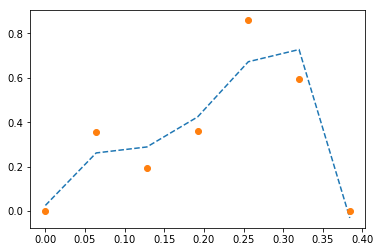

In [7]:
f_champs = archi.get_champions_f()
x_champs = archi.get_champions_x()

f_list = np.array([x[0] for x in f_champs])
i_champ = np.where(f_list==f_list.min())[0][0]

omega=x_champs[i_champ][1]
length_pulse = x_champs[i_champ][0]

print('''Pop transfer of {0}% with:
    length_pulse: {1}us
    omega: {2}MHz
    and pulse shape of...'''.format(*[np.round(x,3) for x in [100*(1-f_champs[i_champ][0]),
                                                              length_pulse,
                                                              omega/(2*np.pi)]])
      )

x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
y_list=x_champs[i_champ][2:]
pulse_fn = lambda t_list: [np.piecewise(t, [t<=length_pulse], [UnivariateSpline(x_list,y_list,s=0.1,k=4),0]) for t in t_list]

plt.plot(x_list, pulse_fn(x_list),'--', x_list, y_list,'o')

Photon emission: 0.625
Photon emission in |X>, |Y>: 0.312 0.312
Spontaneous emission: 0.372


lambda t_list: [np.piecewise(t,[t<=0.384020954607],[UnivariateSpline([0.0, 0.06400349243453082, 0.12800698486906165, 0.19201047730359247, 0.2560139697381233, 0.32001746217265414, 0.38402095460718494],[0.0, 0.3558913015545603, 0.19336423352359713, 0.3624811233428896, 0.8593274287365329, 0.5962788044362908, 0.0],s=0.1,k=3),0]) for t in t_list]
<function <lambda> at 0x118e7e598>


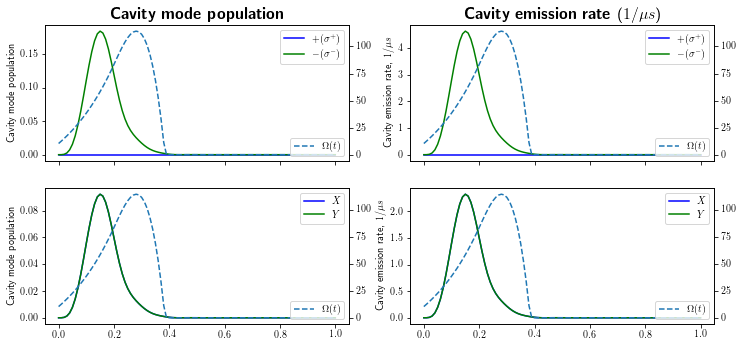

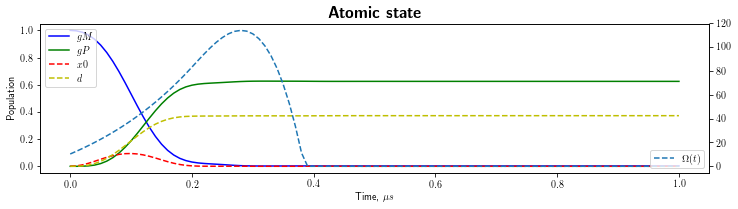

In [10]:
laser_coupling.omega0 = omega
laser_coupling.args_ham['length_pulse'] = length_pulse
laser_coupling.args_ham['x_list'] = x_list
laser_coupling.args_ham['y_list'] = y_list 

runner = ExperimentalRunner(atom=atom,
                        cavity=cavity,
                        laser_couplings=[laser_coupling],
                        cavity_couplings=cavity_couplings,
                        verbose=False)

results = runner.run(psi0=psi0, t_length=t_length, n_steps=n_steps)

plot_results(results)

### Pygmo testing - with migration

In [11]:
import scipy.linalg as la

'''
This is code is taken from the Cubic_Spline.__init__(...) function.
'''
def get_spline_coeffs(a, b, y, alpha=0, beta=0):

    y = np.asarray(y)
    n = y.shape[0] - 1
    h = (b - a)/n

    coeff = np.zeros(n + 3, dtype=y.dtype)
    # Solutions to boundary coeffcients of spline
    coeff[1] = 1/6. * (y[0] - (alpha * h**2)/6) #C2 in paper
    coeff[n + 1] = 1/6. * (y[n] - (beta * h**2)/6) #cn+2 in paper

    # Compressed tridiagonal matrix 
    ab = np.ones((3, n - 1), dtype=float)
    ab[0,0] = 0 # Because top row is upper diag with one less elem
    ab[1, :] = 4
    ab[-1,-1] = 0 # Because bottom row is lower diag with one less elem
    
    B = y[1:-1].copy() #grabs elements y[1] - > y[n-2] for reduced array
    B[0] -= coeff[1]
    B[-1] -=  coeff[n + 1]

    coeff[2:-2] = la.solve_banded((1, 1), ab, B, overwrite_ab=True, 
                    overwrite_b=True, check_finite=False)

    coeff[0] = alpha * h**2/6. + 2 * coeff[1] - coeff[2]
    coeff[-1] = beta * h**2/6. + 2 * coeff[-2] - coeff[-3]
    
    return coeff

In [12]:
'''
Set up system
'''
gamma=3 * 2. * np.pi
branching_ratios = [0,0,1]

atom=Atom(gamma=gamma, branching_ratios=branching_ratios)

# g0=24 * (2*np.pi)
# kappa1,kappa2 = 19 * 2.*np.pi, 0.9 * 2.*np.pi
# deltaP = 20 * 2.*np.pi

g0=4 * (2*np.pi)
kappa1,kappa2 = 2 * 2.*np.pi, 2 * 2.*np.pi
deltaP = 0 * 2.*np.pi

cavity=Cavity(g=g0, kappa1=kappa1, kappa2=kappa2, deltaP=deltaP)

deltaC=0
cavity_couplings = []

for g_state, x_state, delta, deltaM in Atom.get_couplings_sigma_minus(deltaC):
    cavity_couplings.append(CavityCoupling(g0=cavity.g,
                                           g=g_state,
                                           x=x_state,
                                           deltaC=delta,
                                           deltaM=deltaM))
    
deltaL=0
length_pulse = 0.8
omega0=20 * 2 * np.pi
n_points = 21

x_list=np.array(np.linspace(0,length_pulse,n_points+2)).astype(float)
y_list=np.sin((np.pi/length_pulse) * x_list).astype(float)

coeffs = get_spline_coeffs(x_list[0],x_list[-1],y_list)

pulse_c_str = \
'''
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double complex pulse_c(float t, float t_start, float t_end, double[::1] coeffs):
    if t<t_end: return interp(t, t_start, t_end, coeffs)
    else: return 0
'''

pulse_c_str_wg = \
'''
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double complex pulse_c(float t, float t_start, float t_end, double[::1] coeffs) with gil:
    if t<t_end: return interp(t, t_start, t_end, coeffs)
    else: return 0
'''

laser_coupling = LaserCoupling(omega0=omega0,
                               g="gM",
                               x="x0",
                               deltaL=0,
                               args_ham={"length_pulse": length_pulse,
                                         "x_list": x_list,
                                         "y_list": y_list,
                                         "pulse_coeffs": coeffs},
                               pulse_shape=("pulse_c(t, 0, length_pulse, pulse_coeffs)"),
                               setup_pyx=[''],
                               add_pyx=[pulse_c_str]
                               )
# 
# laser_coupling = LaserCoupling(omega0=omega0,
#                                g="gM",
#                                x="x0",
#                                deltaL=0,
#                                args_ham={"length_pulse":float(length_pulse),
#                                          "x_list":x_list,
#                                          "y_list":y_list},
#                                pulse_shape=("np.piecewise(t,"
#                                             "[t<=length_pulse],"
#                                             "[UnivariateSpline(x_list,y_list,s=0.1,k=3)" 
#                                             ","
#                                             "0])"),
#                                setup_ham=["from scipy.interpolate import UnivariateSpline"]
#                                )
cyOptions.error_on_unknown_names = True

In [13]:
t_length=1
n_steps=101
psi0=['gM',0,0]

omega_max = 50.0*2*np.pi
l_pulse_max = 0.8

# omega_grad_max = omega_max / (l_pulse_max/5)
# grad_penalty = 1/(n_points-1)
# max_turns = 2
# turning_penalty = 0.1

class PulseOptimisation():
    def __init__(self, dim):
        self.dim = dim
        self.n_points = self.dim - 2
                    
    def fitness(self, x):
        length_pulse, omega = x[:2]
        t_list, dt =np.linspace(0,length_pulse,self.n_points, retstep=True)
        t_list=np.array(t_list).astype(float)
        # t_step = length_pulse / (self.n_points-1)
        y_list = x[2:]
        
        dy_list = np.diff(y_list)
        dydt_list = omega*np.abs(dy_list / dt)
        n_turns = np.sum(np.diff(np.signbit(dy_list)))
        # print(n_turns)
        # if n_turns > max_turns:
        #     return [turning_penalty]
        
        laser_coupling.omega0 = omega
        laser_coupling.args_ham['length_pulse'] = length_pulse
        laser_coupling.args_ham["pulse_coeffs"]: get_spline_coeffs(t_list[0],t_list[-1],y_list)
        laser_coupling.args_ham['x_list'] = t_list
        laser_coupling.args_ham['y_list'] = y_list
        
        # print('Exp.__fitness__, PID:', os.getpid(),
        #       ', Process: ', multiprocessing.current_process().pid,
        #       ', warehouse: ', [ham.name for ham in ham_pipe.get_all()],
        #       ', repr(warehouse): ', repr(ham_pipe))
        
        runner = ExperimentalRunner(atom=atom,
                                cavity=cavity,
                                laser_couplings=[laser_coupling],
                                cavity_couplings=cavity_couplings,
                                verbose=False)
        
        # results = runner.run(psi0=psi0, n_steps=n_steps, t_length=t_length)
        results = runner.run(psi0=psi0, t_length=t_length, n_steps=n_steps)
        
        fit = 1-results.get_atomic_population(['gP'],-1)[-1]
        # fit+=sum([grad_penalty if x else 0 for x in (dydt_list - omega_grad_max) > 0])
        # if n_turns > max_turns:
        #     fit+=turning_penalty*(n_turns-max_turns)
        # else: print('hit:', n_turns)
        
        return [fit]
        
        # return [1-results.get_atomic_population(['gP'])[0][-1]] + (dydt_list - omega_grad_max).tolist()
    
    def get_bounds(self):
        return ([0]*self.dim,[l_pulse_max, omega_max] + [0] + [1]*(self.n_points-2) + [0])
    
    # def get_nic(self):
    #     return self.n_points - 1
    #     
    # def get_nec(self):
    #     return 0
        
    def get_name(self):
        return "Pulse Optimisation"
    
    def get_extra_info(self):
        lb, ub = self.get_bounds()
        bounds = list(zip(*[lb,ub]))
        info = """Optimising over varable: limits
            length_pulse: {0}
            omega: {1}
            {2} pulse shape points: {3}""".format(bounds[0],bounds[1],self.n_points,bounds[3])
        
        return info

In [14]:
def migrate(archi, n_isl):
    f_champs = archi.get_champions_f()
    x_champs = archi.get_champions_x()
    
    f_list = np.array([x[0] for x in f_champs])
    i_champ = np.where(f_list==f_list.min())[0][0]
    
    f_champ = f_champs[i_champ]
    x_champ = x_champs[i_champ]

    for isl in [archi.__getitem__(i) for i in range(n_isl)]:
        if i != i_champ:
            pop = isl.get_population()
            i_worst = pop.worst_idx()
            pop.set_xf(i_worst, x_champ, f_champ)
            isl.set_population(pop)

In [15]:
n_isl = 4
n_cycles = 2

algo = pg.algorithm(pg.de1220(gen = 4, ftol=0.01, memory=True))
algo.set_verbosity(5)

prob = pg.problem(PulseOptimisation(n_points+2))

pg.mp_island.init_pool()

archi = pg.archipelago(n = n_isl,
                       algo = algo,
                       prob = prob,
                       # pop_size = 2*(n_points+2),
                       pop_size = 30,
                       udi = pg.mp_island())

t_start = time.time()

i=0
while i<n_cycles:
    archi.evolve()
    print(archi)
    archi.wait_check()
    migrate(archi, n_isl)
    i+=1

print('Done in {0}s'.format(np.round(time.time()-t_start),3))

Number of islands: 4
Status: busy

Islands summaries:

	#  Type                    Algo                                                  Prob                Size  Status  
	-------------------------------------------------------------------------------------------------------------------
	0  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    
	1  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    
	2  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    
	3  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    



Number of islands: 4
Status: busy

Islands summaries:

	#  Type                    Algo                                                  Prob                Size  Status  
	-------------------------------------------------------------------------------------------------------------------
	0  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    
	1  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    
	2  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    
	3  Multiprocessing island  sa-DE1220: Self-adaptive Differential Evolution 1220  Pulse Optimisation  30    busy    



Done in 33.0s


Pop transfer of 67.309% with:
    length_pulse: 0.732us
    omega: 6.892MHz
    and pulse shape of...


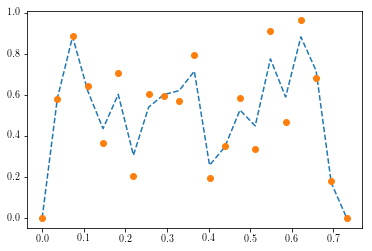

In [16]:
f_champs = archi.get_champions_f()
x_champs = archi.get_champions_x()

f_list = np.array([x[0] for x in f_champs])
i_champ = np.where(f_list==f_list.min())[0][0]

omega=x_champs[i_champ][1]
length_pulse = x_champs[i_champ][0]

print('''Pop transfer of {0}% with:
    length_pulse: {1}us
    omega: {2}MHz
    and pulse shape of...'''.format(*[np.round(x,3) for x in [100*(1-f_champs[i_champ][0]),
                                                              length_pulse,
                                                              omega/(2*np.pi)]])
      )

x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
y_list=x_champs[i_champ][2:]
pulse_fn = lambda t_list: [np.piecewise(t, [t<=length_pulse], [UnivariateSpline(x_list,y_list,s=0.1,k=3),0]) for t in t_list]

plt.plot(x_list, pulse_fn(x_list),'--', x_list, y_list,'o')

Photon emission: 0.673
Photon emission in |X>, |Y>: 0.337 0.337
Spontaneous emission: 0.31


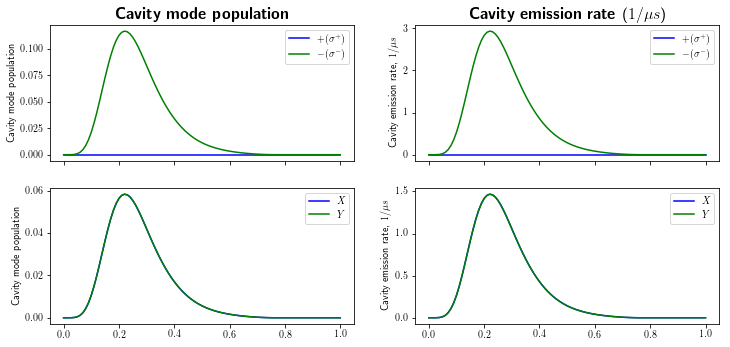

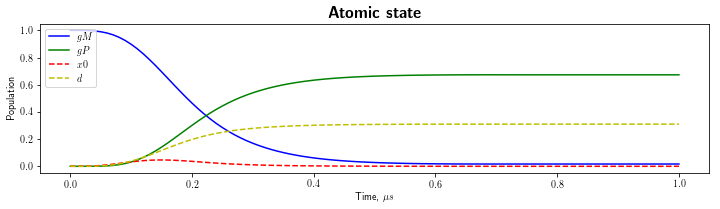

In [17]:
laser_coupling.omega0 = omega
laser_coupling.args_ham['length_pulse'] = length_pulse
laser_coupling.args_ham['pulse_coeffs']: get_spline_coeffs(x_list[0],x_list[-1],y_list)
laser_coupling.args_ham['x_list'] = x_list
laser_coupling.args_ham['y_list'] = y_list 

runner = ExperimentalRunner(atom=atom,
                        cavity=cavity,
                        laser_couplings=[laser_coupling],
                        cavity_couplings=cavity_couplings,
                        verbose=False)

results = runner.run(psi0=psi0, t_length=t_length, n_steps=n_steps)

plot_results(results, plot_pulse=False)

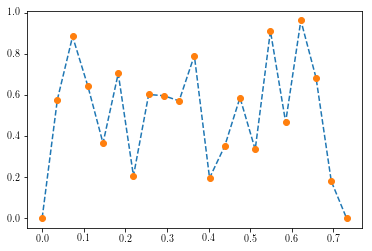

In [18]:
from qutip.cy.interpolate import interp

def pulse(t, t_start, t_end, coeffs):
    if t<t_end: return interp(t, t_start, t_end, coeffs)
    else: return 0
    
x_list=np.array(np.linspace(0,length_pulse,n_points)).astype(float)
y_list=x_champs[i_champ][2:]

coeffs = get_spline_coeffs(x_list[0],x_list[-1],y_list)

plt.plot(x_list, [pulse(t, x_list[0],x_list[-1], coeffs) for t in x_list],'--', x_list, y_list,'o')